# Jonathan Halverson
# Friday, January 12, 2018
# Part 2: Classifying Reber versus non-Reber grammars using an RNN

## This time with one-hot encoding (better)

In [1]:
import numpy as np
import cPickle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
f = open('X_correct_one_hot.reb', 'rb')
X_correct = cPickle.load(f)
y_correct = cPickle.load(f)
L_correct = cPickle.load(f)
f.close()

In [3]:
f = open('X_incorrect_one_hot.reb', 'rb')
X_incorrect = cPickle.load(f)
y_incorrect = cPickle.load(f)
L_incorrect = cPickle.load(f)
f.close()

In [4]:
X_correct[0], y_correct[0], L_correct[0]

(array([[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        

In [5]:
X_incorrect[0], y_incorrect[0], L_incorrect[0]

(array([[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        

### Make training and testing sets

In [6]:
ind = np.arange(y_correct.size + y_incorrect.size)
np.random.shuffle(ind)

In [7]:
X_cmb = np.append(X_correct, X_incorrect, axis=0)[ind]
y_cmb = np.append(y_correct, y_incorrect, axis=0)[ind]
L_cmb = np.append(L_correct, L_incorrect, axis=0)[ind]

In [8]:
test_proportion = 0.2
N_train = int((1.0 - test_proportion) * y_cmb.size)
X_train = X_cmb[:N_train]
y_train = y_cmb[:N_train]
L_train = L_cmb[:N_train]
X_test = X_cmb[N_train:]
y_test = y_cmb[N_train:]
L_test = L_cmb[N_train:]

In [9]:
def fetch_batch(batch_size):
     ind = np.random.choice(np.arange(y_train.size), size=batch_size, replace=False)
     return X_train[ind], y_train[ind], L_train[ind]

### Create the TF graph

In [10]:
tf.reset_default_graph()

In [11]:
n_inputs = 7
n_steps = 37
n_neurons = 50

In [12]:
X = tf.placeholder(dtype=tf.float32, shape=(None, None, n_inputs))
y = tf.placeholder(dtype=tf.int32, shape=(None))
L = tf.placeholder(dtype=tf.int32, shape=(None))

In [13]:
#cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
#cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, state_is_tuple=False, use_peepholes=True)
cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32, sequence_length=L)
#prob_positive = tf.layers.dense(states, units=1, activation=tf.sigmoid)
# only use state from last time step (sequence to vector)
logits = tf.layers.dense(states, units=1, activation=None)
y_proba = tf.nn.sigmoid(logits, name="y_proba")

In [14]:
#loss = tf.losses.log_loss(y, tf.squeeze(prob_positive))
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(tf.reshape(y, (-1, 1)), tf.float32), logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(loss)

In [15]:
#y_pred = tf.cast(tf.squeeze(prob_positive) > 0.5, tf.int32)
y_pred = tf.cast(logits > 0.0, tf.int32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.reshape(y, (-1, 1)), y_pred), tf.float32))

In [16]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Execute the graph

In [17]:
batch_size = 100
epochs = 10

In [18]:
step_acc_loss = []
with tf.Session() as sess:
     init.run()
     for epoch in range(epochs):
          iterations = y_train.size // batch_size
          for iteration in range(iterations):
               X_batch, y_batch, L_batch = fetch_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch, L:L_batch})
               if iteration % 100 == 0:
                    J = loss.eval(feed_dict={X:X_test, y:y_test, L:L_test})
                    acc = accuracy.eval(feed_dict={X:X_test, y:y_test, L:L_test})
                    step = epoch * iterations  + iteration
                    print(step, "log loss:", J, "accuracy:", acc)
                    step_acc_loss.append((step, acc, J))
          saver.save(sess, "my_reber_classifier")

(0, 'log loss:', 0.69386691, 'accuracy:', 0.50185001)
(100, 'log loss:', 0.47883654, 'accuracy:', 0.83969998)
(200, 'log loss:', 0.17240261, 'accuracy:', 0.96055001)
(300, 'log loss:', 0.089048833, 'accuracy:', 0.96509999)
(400, 'log loss:', 0.024129568, 'accuracy:', 0.99484998)
(500, 'log loss:', 0.013300771, 'accuracy:', 0.99675)
(600, 'log loss:', 0.014338809, 'accuracy:', 0.99655002)
(700, 'log loss:', 0.0068903994, 'accuracy:', 0.99755001)
(800, 'log loss:', 0.0042721694, 'accuracy:', 0.99935001)
(900, 'log loss:', 0.0025273599, 'accuracy:', 0.99975002)
(1000, 'log loss:', 0.001805854, 'accuracy:', 0.99984998)
(1100, 'log loss:', 0.0013985171, 'accuracy:', 0.99989998)
(1200, 'log loss:', 0.001397399, 'accuracy:', 0.99980003)
(1300, 'log loss:', 0.0009956928, 'accuracy:', 0.99989998)
(1400, 'log loss:', 0.0083006341, 'accuracy:', 0.99835002)
(1500, 'log loss:', 0.0096517792, 'accuracy:', 0.99790001)
(1600, 'log loss:', 0.0016008854, 'accuracy:', 0.99984998)
(1700, 'log loss:', 0.00

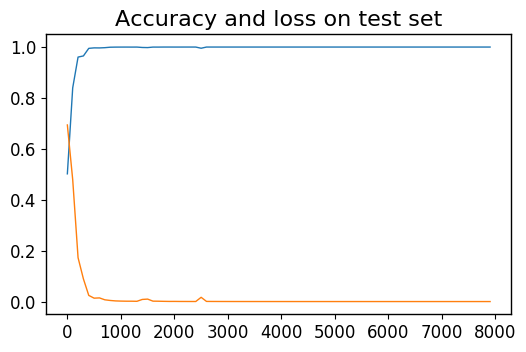

In [19]:
step, acc, loss = zip(*step_acc_loss)
plt.plot(step, acc)
plt.plot(step, loss)
plt.title('Accuracy and loss on test set')

The model works very well.

In [20]:
# note that geron uses a different grammar at this stage with B appearing twice
chars = ['B', 'E', 'P', 'S', 'T', 'V', 'X']
test_strings = ['BTXXTVPXTTVPXTVPXTTVPXTTTTTTTVPXTTTVPXVPXTTTTTVPXVPTE',
                'BTXXTVPXTTVPXTVPXTTVPXTTTTTTTVPXTTTVPXVPXTTTTTVPXVPSE',
                "BTSSXSE", "BTXXTVPXVPXTTVPXTVPSE", "BXXPPTTTSPPTTSTPXVE"]

In [21]:
X_test = []
trans = dict([(u, v) for u, v in zip(chars, range(len(chars)))])
for sample in test_strings:
     letters = [character for character in sample]
     ohe = np.zeros(shape=(len(test_strings[0]), len(chars)), dtype=np.int32)
     for i, char in enumerate(letters):
          ohe[i, trans[char]] = 1
     X_test.append(ohe)

In [22]:
with tf.Session() as sess:
     saver.restore(sess, "my_reber_classifier")
     #y_proba_val = prob_positive.eval(feed_dict={X: X_test, L:[53, 53, 7, 21, 19]})
     y_proba_val = y_proba.eval(feed_dict={X:X_test, L:[53, 53, 7, 21, 19]})

INFO:tensorflow:Restoring parameters from my_reber_classifier


In [23]:
y_proba_val

array([[  2.28130236e-01],
       [  9.99985814e-01],
       [  9.99997497e-01],
       [  9.99998093e-01],
       [  1.60930144e-10]], dtype=float32)

Overall the performance is excellent. The first and last grammars are incorrect and the model predicts this perfectly. The GRU cell has long short-term memory so it is able to deal with sequences that are longer than the training sequences.